# Week 5 Assignment for the Capstone Project - Part II: Data Analysis

Developed by Yongkang Liu  
January 08, 2020
<a name="top"></a>  

In this project, I study how the subways passengers are distributed in time and spatial domains in Manhattan. The insight will help to determine the placement of new restaurants and types of cuisain that would be popular.

We will use the density of passengers of MTA system and the current density of restaurants near the metro stations to show any new business opportunities with the target MTA passengers. Due to the limited information, we only use the number of restaurants without considerations of the capacity.

A per-site survey is also shown to pick a specific site and discuss more customized analysis results. 

Limited by time, we only focus on one week of data. This method can also be extended to evaluate multiple weeks of data to exhibit the seasonal variation or verify the findings in a longer observation window, e.g., based on years of data.

In [79]:
# import libraries
import pandas as pd

import datetime # used to treat date and time information

import folium # Visualize stations in the map

import requests # library to handle requests

import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

# Visualize the analysis result
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

## Data Preprocessing 

Some further work is needed for the subway data before being employed with the Foursquare API.

In [80]:
# Load the data prepared in the Week 4 assignment
df_tt_count = pd.read_csv("modified_turntile_data.csv")
print(f'the imported data size: {df_tt_count.shape}')
df_tt_count.head(3)

# Optional: Check the data first
# df_tt_count.describe()
# df_tt_count.dtypes

the imported data size: (86525, 17)


,Unnamed: 0,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,STATION_IDX,SEARCH_ID,LOCATION,ENTRIES_DIFF,EXITS_DIFF
0,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/26/2019,04:00:00,REGULAR,7247336,2455499,t0000000,"59 ST,NQR456W,BMT,t0000000","(40.762526, -73.967967)",14.0,8.0
1,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/26/2019,08:00:00,REGULAR,7247351,2455532,t0000000,"59 ST,NQR456W,BMT,t0000000","(40.762526, -73.967967)",15.0,33.0
2,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/26/2019,12:00:00,REGULAR,7247463,2455623,t0000000,"59 ST,NQR456W,BMT,t0000000","(40.762526, -73.967967)",112.0,91.0


### Adding new columns to understand data

#### Add one column to have the day of week
Each row of the data contains the date and time information regarding the moment when data was collected. I first treat the date and time information.

In [81]:
''' # an example of using the datetime module
dt = '21/03/2012'
day, month, year = (int(x) for x in dt.split('/'))  
tm = '04:00:00'
HH, MM, SS = (int(x) for x in tm.split(':'))
print(f'HH:{HH}, MM:{MM}, SS:{SS}')
ans = datetime.date(year, month, day)
ans.strftime("%A")
print(f'The date {dt} is {ans.strftime("%A")}, Day {ans.weekday()+1} in a week')
'''

# define a function to get the day of week for a specific date
def get_day_week(dt):
    month, day, year = (int(x) for x in dt.split('/')) 
    if month not in [x+1 for x in list(range(12))]:
        print(f"month out of range: {day}/{month}/{year}")
    #return datetime.date(year, month, day).strftime("%A")
    return datetime.date(year, month, day).weekday()+1
    # Monday - Sunday: 1 - 7

In [82]:
df_tt_count['DAY_WEEK'] = df_tt_count.DATE.apply(get_day_week)

#### Add one column to show the total ridership

A passenger may take the subway multiple times a day. However, the turnstile only records how many passengers enter or exit through it without their identity information. In the following analysis, entries and exists in a single collection period (i.e., 4 hours) are treated as independent events. Therefore, the total count of passengers in a station contains both entries and exists. A new column is added into the dataframe to show the sum.

In [83]:
df_tt_count['PASSENGERS'] = df_tt_count[["ENTRIES_DIFF","EXITS_DIFF"]].apply(lambda x: x.ENTRIES_DIFF+x.EXITS_DIFF, axis=1)

#### Add four new columns to indicate the count of each dining period

Considering there are different neighborhoods in NYC with different business activities, the passenger counts at different locations may vary with time and have their own peak and down time.

Since I would like to study the relationship between subway ridership and the coffee shop business, I use a simple classification that roughly divides the 24 hours of a day into four dining periods: breakfast, lunch, supper, and night.
* breakfast (B): 05:00 - 11:00
* lunch (L): 11:00 - 16:00
* supper (S): 16:00 - 22:00
* night (N): 22:00 - 05:00 (day+1)

Since the turnstile data is collected every 4 hours, if the collection period happens to cross two dining periods, the collected passenger number will be proportionally allocated to the counts of two adjacent periods.


In [84]:
# The proportion is predetermined and saved in a csv table.
df_time_div = pd.read_csv("dining_time_windows.csv")
df_time_div.head()

,ReportTime,Breakfast,Lunch,Supper,Night
0,0,0.0,0.0,0.0,1.0
1,1,0.0,0.0,0.0,1.0
2,2,0.0,0.0,0.0,1.0
3,3,0.0,0.0,0.0,1.0
4,4,0.0,0.0,0.0,1.0


In [85]:
df_time_div['Ratio']=df_time_div[['Breakfast', 'Lunch', "Supper", 'Night']].apply(lambda x: [x.Breakfast, x.Lunch, x.Supper, x.Night], axis=1)

dict_time_ratio = {v: k for v, k in enumerate(df_time_div.Ratio.tolist())}

def time_to_ratio(tm):
    HH, MM, SS = (int(x) for x in tm.split(':'))
    hh = int(HH)
    mm = int(MM)
    if mm > 30:
        hh += 1   # e.g., 08:45 -> 09:00
    hh = hh % 24 
    return dict_time_ratio[hh]

df_tt_count["Ratio"]=df_tt_count.TIME.apply(time_to_ratio)
df_tt_count["HourCounts"]=df_tt_count[["PASSENGERS", "Ratio"]].apply(lambda x: [round(x.PASSENGERS*i) for i in x.Ratio], axis=1)

In [86]:
df_tt_slim = df_tt_count[['STATION_IDX', 'STATION', 'LINENAME', 'DAY_WEEK', 'LOCATION', 'PASSENGERS', 'ENTRIES_DIFF', 'EXITS_DIFF', 'HourCounts']].copy()
df_tt_slim.rename(columns={'ENTRIES_DIFF': 'ENTRIES', 'EXITS_DIFF': 'EXITS'}, inplace=True)
df_tt_slim.head()

,STATION_IDX,STATION,LINENAME,DAY_WEEK,LOCATION,PASSENGERS,ENTRIES,EXITS,HourCounts
0,t0000000,59 ST,NQR456W,6,"(40.762526, -73.967967)",22.0,14.0,8.0,"[0.0, 0.0, 0.0, 22.0]"
1,t0000000,59 ST,NQR456W,6,"(40.762526, -73.967967)",48.0,15.0,33.0,"[48.0, 0.0, 0.0, 0.0]"
2,t0000000,59 ST,NQR456W,6,"(40.762526, -73.967967)",203.0,112.0,91.0,"[152.0, 51.0, 0.0, 0.0]"
3,t0000000,59 ST,NQR456W,6,"(40.762526, -73.967967)",348.0,292.0,56.0,"[0.0, 348.0, 0.0, 0.0]"
4,t0000000,59 ST,NQR456W,6,"(40.762526, -73.967967)",458.0,404.0,54.0,"[0.0, 0.0, 458.0, 0.0]"


In [87]:
df_tt_slim[['B_Counts', 'L_Counts', 'S_Counts', 'N_Counts']] = pd.DataFrame(df_tt_slim['HourCounts'].values.tolist(), index=df_tt_slim.index)  
df_tt_slim.drop("HourCounts", axis=1, inplace=True)
df_tt_slim.head()

,STATION_IDX,STATION,LINENAME,DAY_WEEK,LOCATION,PASSENGERS,ENTRIES,EXITS,B_Counts,L_Counts,S_Counts,N_Counts
0,t0000000,59 ST,NQR456W,6,"(40.762526, -73.967967)",22.0,14.0,8.0,0.0,0.0,0.0,22.0
1,t0000000,59 ST,NQR456W,6,"(40.762526, -73.967967)",48.0,15.0,33.0,48.0,0.0,0.0,0.0
2,t0000000,59 ST,NQR456W,6,"(40.762526, -73.967967)",203.0,112.0,91.0,152.0,51.0,0.0,0.0
3,t0000000,59 ST,NQR456W,6,"(40.762526, -73.967967)",348.0,292.0,56.0,0.0,348.0,0.0,0.0
4,t0000000,59 ST,NQR456W,6,"(40.762526, -73.967967)",458.0,404.0,54.0,0.0,0.0,458.0,0.0


#### Group turnstile data (of multiple turnstiles and multiple collections) by the station (per day)

In [88]:
# Get the counts in each period for a station in each day
df_tt_slim_gp = df_tt_slim.groupby(['STATION_IDX', 'STATION', 'LINENAME', 'LOCATION', "DAY_WEEK"], as_index=False).sum()
df_tt_slim_gp.head(8)

,STATION_IDX,STATION,LINENAME,LOCATION,DAY_WEEK,PASSENGERS,ENTRIES,EXITS,B_Counts,L_Counts,S_Counts,N_Counts
0,t0000000,59 ST,NQR456W,"(40.762526, -73.967967)",1,20961.0,12430.0,8531.0,6030.0,5325.0,7767.0,1839.0
1,t0000000,59 ST,NQR456W,"(40.762526, -73.967967)",2,22056.0,13185.0,8871.0,6141.0,5729.0,7874.0,2312.0
2,t0000000,59 ST,NQR456W,"(40.762526, -73.967967)",3,22499.0,13504.0,8995.0,6430.0,5535.0,7960.0,2574.0
3,t0000000,59 ST,NQR456W,"(40.762526, -73.967967)",4,21093.0,12810.0,8283.0,6224.0,5127.0,7085.0,2657.0
4,t0000000,59 ST,NQR456W,"(40.762526, -73.967967)",5,21810.0,13062.0,8748.0,5918.0,5711.0,7616.0,2565.0
5,t0000000,59 ST,NQR456W,"(40.762526, -73.967967)",6,13457.0,7754.0,5703.0,2939.0,5052.0,5054.0,412.0
6,t0000000,59 ST,NQR456W,"(40.762526, -73.967967)",7,11414.0,6603.0,4811.0,1885.0,3202.0,3254.0,3073.0
7,t0001001,5 AV/59 ST,NQRW,"(40.764811, -73.973347)",1,27881.0,15751.0,12130.0,7571.0,7995.0,11607.0,703.0


In [89]:
df_tt_slim_gp.STATION_IDX.nunique()

145

It is easy to identify that there exists a significant difference in the ridership between the weekday and weekend. I make two different data sets, one for each.

In [90]:
# Get Weekday data
df_tt_slim_workday = df_tt_slim_gp[df_tt_slim_gp.DAY_WEEK.isin([1, 2, 3, 4, 5])]
df_tt_slim_workday = df_tt_slim_workday.groupby(['STATION_IDX', 'STATION', 'LINENAME', 'LOCATION'], as_index=False).mean()
df_tt_slim_workday = df_tt_slim_workday.drop("DAY_WEEK", axis=1)
df_tt_slim_workday['LATITUDE'] = df_tt_slim_workday['LOCATION'].apply(lambda x: x.split(',')[0][1:])
df_tt_slim_workday['LONGITUDE'] = df_tt_slim_workday['LOCATION'].apply(lambda x: x.split(',')[1][:-1])
df_tt_slim_workday.head()

# save data for future analysis
df_tt_slim_workday.to_csv('turnstile_workday.csv')

In [91]:
# Get Weekend data
df_tt_slim_weekend = df_tt_slim_gp[df_tt_slim_gp.DAY_WEEK.isin([6, 7])]
df_tt_slim_weekend = df_tt_slim_weekend.groupby(['STATION_IDX', 'STATION', 'LINENAME', 'LOCATION'], as_index=False).mean()
df_tt_slim_weekend = df_tt_slim_weekend.drop("DAY_WEEK", axis=1)
df_tt_slim_weekend['LATITUDE'] = df_tt_slim_weekend['LOCATION'].apply(lambda x: x.split(',')[0][1:])
df_tt_slim_weekend['LONGITUDE'] = df_tt_slim_weekend['LOCATION'].apply(lambda x: x.split(',')[1][:-1])
df_tt_slim_weekend.head()

# save data for future analysis
df_tt_slim_weekend.to_csv('turnstile_weekend.csv')

### Data Visualization

In [92]:
# Manhattan coordinate
latitude = 40.7831
longitude = -73.9712

map_newyork = folium.Map(location=[latitude, longitude], zoom_start=12) # generate map centred around the Conrad Hotel


for i in range(df_tt_slim_workday.shape[0]):
    label = f'{df_tt_slim_workday.iloc[i]["STATION"]},"{df_tt_slim_workday.iloc[i]["LINENAME"]}"'
    label = folium.Popup(label, parse_html=True)
    lat = float(df_tt_slim_workday.iloc[i]['LOCATION'].split(',')[0][1:])
    lng = float(df_tt_slim_workday.iloc[i]['LOCATION'].split(',')[1][:-1])
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork) 

map_newyork    

In [93]:
print(f'On average, the subway ridership in Manhattan in a weekday is {df_tt_slim_workday.PASSENGERS.sum()}')
print(f'On average, the subway ridership in Manhattan in a weekend is {df_tt_slim_weekend.PASSENGERS.sum()}')
#df_tt_slim_workday.shape
#df_tt_slim_weekend.shape

On average, the subway ridership in Manhattan in a weekday is 5887125.0
On average, the subway ridership in Manhattan in a weekend is 2728774.5


In [94]:
df_tt_slim_workday.describe()

,PASSENGERS,ENTRIES,EXITS,B_Counts,L_Counts,S_Counts,N_Counts
count,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000
mean,40600.862069,21923.372414,18677.489655,11776.075862,10973.804138,14013.344828,3837.747586
std,37881.509149,19091.244090,19058.270841,11523.156799,9862.231890,13453.451401,3711.979981
min,2755.600000,1965.200000,198.800000,887.400000,790.200000,739.600000,133.400000
25%,18642.800000,10797.400000,7092.800000,5489.400000,4935.600000,5876.800000,1550.400000
50%,29367.200000,17305.200000,12970.600000,8110.600000,8542.600000,10799.600000,2657.400000
75%,50093.600000,25776.200000,23467.200000,14629.400000,13631.400000,16243.200000,4642.000000
max,296721.000000,151258.600000,145462.400000,94817.200000,77872.600000,104526.000000,19505.200000


In [95]:
df_workday_top10_full = df_tt_slim_workday.sort_values(by=['PASSENGERS'], ascending=False).head(10).copy()
df_workday_top10_b = df_tt_slim_workday.sort_values(by=['B_Counts'], ascending=False).head(10).copy()
df_workday_top10_l = df_tt_slim_workday.sort_values(by=['L_Counts'], ascending=False).head(10).copy()
df_workday_top10_s = df_tt_slim_workday.sort_values(by=['S_Counts'], ascending=False).head(10).copy()
df_workday_top10_n = df_tt_slim_workday.sort_values(by=['N_Counts'], ascending=False).head(10).copy()

In [96]:
df_weekend_top10_full = df_tt_slim_weekend.sort_values(by=['PASSENGERS'], ascending=False).head(10).copy()
df_weekend_top10_b = df_tt_slim_weekend.sort_values(by=['B_Counts'], ascending=False).head(10).copy()
df_weekend_top10_l = df_tt_slim_weekend.sort_values(by=['L_Counts'], ascending=False).head(10).copy()
df_weekend_top10_s = df_tt_slim_weekend.sort_values(by=['S_Counts'], ascending=False).head(10).copy()
df_weekend_top10_n = df_tt_slim_weekend.sort_values(by=['N_Counts'], ascending=False).head(10).copy()

In [97]:
df_workday_top10_full

,STATION_IDX,STATION,LINENAME,LOCATION,PASSENGERS,ENTRIES,EXITS,B_Counts,L_Counts,S_Counts,N_Counts,LATITUDE,LONGITUDE
137,t3093280,GRD CNTRL-42 ST,4567S,"(40.752769, -73.979189)",296721.0,151258.6,145462.4,94817.2,77872.6,104526.0,19505.2,40.752769,-73.979189
59,t1048135,34 ST-PENN STA,ACE,"(40.752287, -73.993391)",169002.6,88529.8,80472.8,53451.4,41898.6,56560.0,17092.6,40.752287,-73.993391
26,t1002134,42 ST-PORT AUTH,ACENQRS1237W,"(40.757308, -73.989735)",147472.2,79404.8,68067.4,48583.6,33275.4,50319.2,15294.8,40.757308,-73.989735
27,t1003005,34 ST-HERALD SQ,BDFMNQRW,"(40.749719, -73.987823)",145612.2,72651.2,72961.0,39634.8,37784.8,53106.2,15086.4,40.749719,-73.987823
13,t0005008,14 ST-UNION SQ,LNQR456W,"(40.734789, -73.99073)",143912.6,75390.6,68522.0,34557.6,40956.4,54170.0,14228.8,40.734789,-73.99073
74,t1072212,47-50 STS ROCK,BDFM,"(40.758663, -73.981329)",134437.0,65441.8,68995.2,43170.8,33664.6,47067.6,10534.0,40.758663,-73.981329
117,t3085004,TIMES SQ-42 ST,1237ACENQRSW,"(40.755983, -73.986229)",129204.4,62216.4,66988.0,34120.4,32252.4,44081.6,18750.0,40.755983,-73.986229
53,t1045133,59 ST COLUMBUS,ABCD1,"(40.768296, -73.981736)",117432.4,64101.0,53331.4,31164.0,33672.0,38426.0,14170.4,40.768296,-73.981736
60,t1049137,W 4 ST-WASH SQ,ABCDEFM,"(40.732338, -74.000495)",92320.8,47039.6,45281.2,20731.8,23328.6,34123.4,14136.2,40.732338,-74.000495
75,t1073213,42 ST-BRYANT PK,BDFM7,"(40.754222, -73.984569)",91523.2,46359.2,45164.0,25836.6,22970.0,33182.4,9534.2,40.754222,-73.984569


In [98]:
df_weekend_top10_full

,STATION_IDX,STATION,LINENAME,LOCATION,PASSENGERS,ENTRIES,EXITS,B_Counts,L_Counts,S_Counts,N_Counts,LATITUDE,LONGITUDE
137,t3093280,GRD CNTRL-42 ST,4567S,"(40.752769, -73.979189)",102504.5,50347.0,52157.5,21607.5,36981.0,32210.0,11703.0,40.752769,-73.979189
26,t1002134,42 ST-PORT AUTH,ACENQRS1237W,"(40.757308, -73.989735)",78547.5,42114.0,36433.5,16990.0,24118.5,26989.5,10449.0,40.757308,-73.989735
59,t1048135,34 ST-PENN STA,ACE,"(40.752287, -73.993391)",77137.0,38313.5,38823.5,15587.0,26296.5,24138.5,11115.0,40.752287,-73.993391
27,t1003005,34 ST-HERALD SQ,BDFMNQRW,"(40.749719, -73.987823)",76149.0,34355.5,41793.5,13872.0,25596.0,25567.5,11113.5,40.749719,-73.987823
53,t1045133,59 ST COLUMBUS,ABCD1,"(40.768296, -73.981736)",65936.5,35169.0,30767.5,12719.5,23501.0,20741.0,8975.0,40.768296,-73.981736
117,t3085004,TIMES SQ-42 ST,1237ACENQRSW,"(40.755983, -73.986229)",63278.5,29922.5,33356.0,10214.0,19209.0,21128.5,12727.0,40.755983,-73.986229
13,t0005008,14 ST-UNION SQ,LNQR456W,"(40.734789, -73.99073)",63174.0,32805.0,30369.0,9772.0,22565.5,23999.0,6838.5,40.734789,-73.99073
60,t1049137,W 4 ST-WASH SQ,ABCDEFM,"(40.732338, -74.000495)",61656.5,30235.5,31421.0,8884.5,18843.5,22881.0,11049.5,40.732338,-74.000495
139,t3095052,86 ST,456,"(40.779492, -73.955589)",51513.5,23331.0,28182.5,10654.0,19070.5,16320.0,5469.0,40.779492,-73.955589
74,t1072212,47-50 STS ROCK,BDFM,"(40.758663, -73.981329)",48007.0,21833.0,26174.0,9266.5,15874.0,15169.5,7697.0,40.758663,-73.981329


In [99]:
# Manhattan coordinate
latitude = 40.7831
longitude = -73.9712

map_newyork_workday = folium.Map(location=[latitude, longitude], zoom_start=12) # generate map centred around the Conrad Hotel

for i in range(df_workday_top10_full.shape[0]):
    label = f'{df_workday_top10_full.iloc[i]["STATION"]},"{df_workday_top10_full.iloc[i]["LINENAME"]}"'
    label = folium.Popup(label, parse_html=True)
    lat = float(df_workday_top10_full.iloc[i]['LATITUDE'])
    lng = float(df_workday_top10_full.iloc[i]['LONGITUDE'])
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.0,
        parse_html=False).add_to(map_newyork_workday)  
    
for i in range(df_weekend_top10_full.shape[0]):
    label = f'{df_weekend_top10_full.iloc[i]["STATION"]},"{df_weekend_top10_full.iloc[i]["LINENAME"]}"'
    label = folium.Popup(label, parse_html=True)
    lat = float(df_weekend_top10_full.iloc[i]['LATITUDE'])
    lng = float(df_weekend_top10_full.iloc[i]['LONGITUDE'])
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork_workday)  

map_newyork_workday  

In [100]:
# Manhattan coordinate
latitude = 40.7831
longitude = -73.9712

map_newyork_workday = folium.Map(location=[latitude, longitude], zoom_start=12) # generate map centred around the Conrad Hotel
    
for i in range(df_workday_top10_b.shape[0]):
    label = f'{df_workday_top10_b.iloc[i]["STATION"]},"{df_workday_top10_b.iloc[i]["LINENAME"]}"'
    label = folium.Popup(label, parse_html=True)
    lat = float(df_workday_top10_b.iloc[i]['LATITUDE'])
    lng = float(df_workday_top10_b.iloc[i]['LONGITUDE'])
    folium.CircleMarker(
        [lat, lng],
        radius=9,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.0,
        parse_html=False).add_to(map_newyork_workday)  
    
for i in range(df_workday_top10_l.shape[0]):
    label = f'{df_workday_top10_l.iloc[i]["STATION"]},"{df_workday_top10_l.iloc[i]["LINENAME"]}"'
    label = folium.Popup(label, parse_html=True)
    lat = float(df_workday_top10_l.iloc[i]['LATITUDE'])
    lng = float(df_workday_top10_l.iloc[i]['LONGITUDE'])
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.0,
        parse_html=False).add_to(map_newyork_workday)
    
for i in range(df_workday_top10_s.shape[0]):
    label = f'{df_workday_top10_s.iloc[i]["STATION"]},"{df_workday_top10_s.iloc[i]["LINENAME"]}"'
    label = folium.Popup(label, parse_html=True)
    lat = float(df_workday_top10_s.iloc[i]['LATITUDE'])
    lng = float(df_workday_top10_s.iloc[i]['LONGITUDE'])
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.0,
        parse_html=False).add_to(map_newyork_workday)
    
for i in range(df_workday_top10_n.shape[0]):
    label = f'{df_workday_top10_n.iloc[i]["STATION"]},"{df_workday_top10_n.iloc[i]["LINENAME"]}"'
    label = folium.Popup(label, parse_html=True)
    lat = float(df_workday_top10_n.iloc[i]['LATITUDE'])
    lng = float(df_workday_top10_n.iloc[i]['LONGITUDE'])
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='black',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=1.0,
        parse_html=False).add_to(map_newyork_workday)

map_newyork_workday  


## Coffee Shops near MTA Stations

Next, it is about to use the Foursquare API to get the nearby venue information at each station.

In this project, I focus on the available options of coffee shops for subway riders. At each station, I use Foursquare API to search venues serving coffee in the radius of 100 m, 200 m, and 300 m. The weekday data is used in the following work. 

The returned data is expected to explain the relationship between the number of coffee shops and the number of subway riders. And I also hope this work can also find the answers to some market planning problem, e.g., how many Starbucks near a subway station.

In [101]:
# The weekday data is used in the following analysis
df_station_coffee = df_tt_slim_weekend[['STATION_IDX', 'STATION', 'LINENAME', 'LATITUDE', 'LONGITUDE']].copy()

# Add more columns to collect data from Foursquare API
df_station_coffee['ShopNum'] = None # expected value: a vector of shop numbers found in the radius of 100m, 200m, and 300m
df_station_coffee['Starbucks'] = None # expected value: the Starbucks number found in the radius of 300m, when "coffee" is searched
df_station_coffee['StarbucksAll'] = None # expected value: the Starbucks number found in the radius of 300m, when "Starbucks" is searched

dict_coffee = {} # save the returned coffee shop information, the key is its Foursquare venue id
dict_starbucks = {} # save the returned Starbucks information, the key is its Foursquare venue id
dict_starbucks_all = {} # save the returned Starbucks information, the key is its Foursquare venue id

df_station_coffee.head()

,STATION_IDX,STATION,LINENAME,LATITUDE,LONGITUDE,ShopNum,Starbucks,StarbucksAll
0,t0000000,59 ST,NQR456W,40.762526,-73.967967,None,None,None
1,t0001001,5 AV/59 ST,NQRW,40.764811,-73.973347,None,None,None
2,t0001002,57 ST-7 AV,NQRW,40.764664,-73.980658,None,None,None
3,t0001003,49 ST,NQRW,40.759901,-73.984139,None,None,None
4,t0002004,TIMES SQ-42 ST,ACENQRS1237W,40.755983,-73.986229,None,None,None


In [2]:
# Input Foursquare API credential
''' For Account Privacy, the Client Information has been Removed '''
CLIENT_ID = "Your_ID" # your Foursquare ID
CLIENT_SECRET = "Your_Secrete" # your Foursquare Secret

VERSION = '20191104'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: Your_ID
CLIENT_SECRET:Your_Secrete


In [103]:
search_query = 'Coffee'
search_radius = [100, 200, 300]

for i in range(df_station_coffee.shape[0]):
    num_vec = []
    num_sb = 0
    
    # get the lat,lng from station data
    lat, lng = float(df_station_coffee.iloc[i]['LATITUDE']), float(df_station_coffee.iloc[i]['LONGITUDE'])
    
    for j in range(len(search_radius)):
        radius = search_radius[j]
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, search_query, radius, LIMIT)
        
        results = requests.get(url).json()
        #print(results)
        num_vec.append(len(results['response']['venues']))    
        
        if search_radius[j] == 300:
            for k in range(len(results['response']['venues'])):
                #print(k)
                #print(result['response']['venues'][k])
                # Add the found venue into the dictionary
                shopId = results['response']['venues'][k]['id']
                shopName = results['response']['venues'][k]['name']
                shopLocLat = results['response']['venues'][k]['location']['lat']
                shopLocLng = results['response']['venues'][k]['location']['lng']
                dict_coffee[shopId] = [shopName, shopLocLat, shopLocLng]
                
                if results['response']['venues'][k]['name'] == 'Starbucks':
                    num_sb += 1
                    dict_starbucks[shopId] = [shopName, shopLocLat, shopLocLng]
                    
    print(f'{i}: {num_vec}, Starbucks: {num_sb}')
    df_station_coffee.at[i, 'ShopNum'] = num_vec
    df_station_coffee.at[i, 'Starbucks'] = num_sb
    
#df_station_coffee.head()

0: [1, 9, 20], Starbucks: 4
1: [1, 3, 7], Starbucks: 1
2: [6, 18, 31], Starbucks: 9
3: [8, 21, 34], Starbucks: 7
4: [7, 20, 50], Starbucks: 6
5: [5, 16, 46], Starbucks: 4
6: [1, 9, 15], Starbucks: 3
7: [3, 20, 50], Starbucks: 2
8: [6, 13, 32], Starbucks: 4
9: [8, 14, 29], Starbucks: 2
10: [7, 16, 30], Starbucks: 2
11: [1, 7, 17], Starbucks: 4
12: [2, 6, 18], Starbucks: 4
13: [8, 24, 33], Starbucks: 1
14: [5, 17, 20], Starbucks: 2
15: [3, 16, 28], Starbucks: 5
16: [4, 10, 16], Starbucks: 4
17: [1, 6, 12], Starbucks: 1
18: [2, 7, 13], Starbucks: 0
19: [1, 10, 34], Starbucks: 7
20: [1, 4, 11], Starbucks: 3
21: [5, 15, 36], Starbucks: 7
22: [5, 19, 33], Starbucks: 2
23: [2, 8, 24], Starbucks: 1
24: [0, 3, 10], Starbucks: 1
25: [3, 6, 9], Starbucks: 1
26: [5, 11, 33], Starbucks: 5
27: [5, 16, 46], Starbucks: 4
28: [1, 9, 14], Starbucks: 1
29: [5, 15, 36], Starbucks: 7
30: [0, 4, 11], Starbucks: 1
31: [1, 3, 11], Starbucks: 3
32: [0, 0, 4], Starbucks: 0
33: [6, 15, 36], Starbucks: 2
34: [7, 

In [104]:
len(dict_coffee)


1021

In [105]:
len(dict_starbucks)

136

In [106]:
search_query = 'Starbucks'
search_radius = [300]

for i in range(df_station_coffee.shape[0]):
    num_sb = 0
    lat, lng = float(df_station_coffee.iloc[i]['LATITUDE']), float(df_station_coffee.iloc[i]['LONGITUDE'])
    
    for j in range(len(search_radius)):
        radius = search_radius[j]
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, search_query, radius, LIMIT)
        results = requests.get(url).json()
        #print(results) 
        if search_radius[j] == 300:
            for k in range(len(results['response']['venues'])):
                if results['response']['venues'][k]['name'] == 'Starbucks':
                    shopId = results['response']['venues'][k]['id']
                    shopName = 'Starbucks'
                    shopLocLat = results['response']['venues'][k]['location']['lat']
                    shopLocLng = results['response']['venues'][k]['location']['lng']
                    dict_starbucks_all[shopId] = [shopName, shopLocLat, shopLocLng]
                    num_sb += 1
                    
    print(f'{i}: Starbucks: {num_sb}')
    df_station_coffee.at[i, 'StarbucksAll'] = num_sb

# Check the search results written in the dataframe
df_station_coffee.head()

0: Starbucks: 6
1: Starbucks: 2
2: Starbucks: 12
3: Starbucks: 11
4: Starbucks: 10
5: Starbucks: 12
6: Starbucks: 5
7: Starbucks: 4
8: Starbucks: 5
9: Starbucks: 4
10: Starbucks: 2
11: Starbucks: 9
12: Starbucks: 7
13: Starbucks: 3
14: Starbucks: 3
15: Starbucks: 11
16: Starbucks: 9
17: Starbucks: 1
18: Starbucks: 0
19: Starbucks: 11
20: Starbucks: 5
21: Starbucks: 12
22: Starbucks: 5
23: Starbucks: 3
24: Starbucks: 5
25: Starbucks: 2
26: Starbucks: 6
27: Starbucks: 12
28: Starbucks: 1
29: Starbucks: 12
30: Starbucks: 2
31: Starbucks: 4
32: Starbucks: 2
33: Starbucks: 5
34: Starbucks: 5
35: Starbucks: 0
36: Starbucks: 1
37: Starbucks: 0
38: Starbucks: 1
39: Starbucks: 0
40: Starbucks: 2
41: Starbucks: 0
42: Starbucks: 0
43: Starbucks: 1
44: Starbucks: 1
45: Starbucks: 1
46: Starbucks: 1
47: Starbucks: 1
48: Starbucks: 0
49: Starbucks: 0
50: Starbucks: 0
51: Starbucks: 1
52: Starbucks: 0
53: Starbucks: 10
54: Starbucks: 5
55: Starbucks: 10
56: Starbucks: 3
57: Starbucks: 6
58: Starbucks

,STATION_IDX,STATION,LINENAME,LATITUDE,LONGITUDE,ShopNum,Starbucks,StarbucksAll
0,t0000000,59 ST,NQR456W,40.762526,-73.967967,"[1, 9, 20]",4,6
1,t0001001,5 AV/59 ST,NQRW,40.764811,-73.973347,"[1, 3, 7]",1,2
2,t0001002,57 ST-7 AV,NQRW,40.764664,-73.980658,"[6, 18, 31]",9,12
3,t0001003,49 ST,NQRW,40.759901,-73.984139,"[8, 21, 34]",7,11
4,t0002004,TIMES SQ-42 ST,ACENQRS1237W,40.755983,-73.986229,"[7, 20, 50]",6,10


In [107]:
# Split the ShopNum into three new columns
df_station_coffee["100M"] = df_station_coffee.apply(lambda x: x.ShopNum[0], axis=1)
df_station_coffee["200M"] = df_station_coffee.apply(lambda x: x.ShopNum[1], axis=1)
df_station_coffee["300M"] = df_station_coffee.apply(lambda x: x.ShopNum[2], axis=1)
df_station_coffee.head()

,STATION_IDX,STATION,LINENAME,LATITUDE,LONGITUDE,ShopNum,Starbucks,StarbucksAll,100M,200M,300M
0,t0000000,59 ST,NQR456W,40.762526,-73.967967,"[1, 9, 20]",4,6,1,9,20
1,t0001001,5 AV/59 ST,NQRW,40.764811,-73.973347,"[1, 3, 7]",1,2,1,3,7
2,t0001002,57 ST-7 AV,NQRW,40.764664,-73.980658,"[6, 18, 31]",9,12,6,18,31
3,t0001003,49 ST,NQRW,40.759901,-73.984139,"[8, 21, 34]",7,11,8,21,34
4,t0002004,TIMES SQ-42 ST,ACENQRS1237W,40.755983,-73.986229,"[7, 20, 50]",6,10,7,20,50


It seems that Foursquare API only returns up to 50 results per query.

In [108]:
# Save the results into a csv for record
df_station_coffee.to_csv("nyc_subway_coffee.csv")

df_station_coffee.head()

# To save the data in the dictionaries
df_dict_shops = pd.DataFrame.from_dict(dict_coffee) 
# First, need to transpose the obtained dataframe from a dictionary since it saves each record in a new column. 
df_dict_shops = df_dict_shops.T
# Create a new index column, as the former index is the ID field
df_dict_shops.reset_index(inplace=True)
# Rename the columns
df_dict_shops.rename(columns={'index': 'ID', 0: 'Name', 1: 'Lat', 2: 'Lng'}, inplace=True)
#df_dict_shops.head()
# Save the shaped dataframe into the csv
df_dict_shops.to_csv("nyc_coffee_shop_loc.csv")

# Follow the above steps to shape another dictionary data and save into csv
df_dict_starbucks = pd.DataFrame.from_dict(dict_starbucks)
df_dict_starbucks = df_dict_starbucks.T
df_dict_starbucks.reset_index(inplace=True)
df_dict_starbucks.rename(columns={'index': 'ID', 0: 'Name', 1: 'Lat', 2: 'Lng'}, inplace=True)
#df_dict_starbucks.head()
df_dict_starbucks.to_csv("nyc_starbucks_loc.csv")

# Follow the above steps to shape another dictionary data and save into csv
df_dict_starbucks_all = pd.DataFrame.from_dict(dict_starbucks_all)
df_dict_starbucks_all = df_dict_starbucks_all.T
df_dict_starbucks_all.reset_index(inplace=True)
df_dict_starbucks_all.rename(columns={'index': 'ID', 0: 'Name', 1: 'Lat', 2: 'Lng'}, inplace=True)
#df_dict_starbucks_all.head()
df_dict_starbucks_all.to_csv("nyc_starbucks_all_loc.csv")

In [109]:
len(df_dict_starbucks_all)

246

## Data Analysis

In this part, we will use the obtained data to get some insight.

In [110]:
# Load data from the saved CSV files
df_station_coffee = pd.read_csv("nyc_subway_coffee.csv")
df_dict_shops = pd.read_csv("nyc_coffee_shop_loc.csv")
df_dict_starbucks = pd.read_csv("nyc_starbucks_loc.csv")
df_dict_starbucks_all = pd.read_csv("nyc_starbucks_all_loc.csv")
df_tt_slim_workday = pd.read_csv("turnstile_workday.csv")

print('Data Loading Done!')

Data Loading Done!


In [111]:
df_station_coffee.head()

,Unnamed: 0,STATION_IDX,STATION,LINENAME,LATITUDE,LONGITUDE,ShopNum,Starbucks,StarbucksAll,100M,200M,300M
0,0,t0000000,59 ST,NQR456W,40.762526,-73.967967,"[1, 9, 20]",4,6,1,9,20
1,1,t0001001,5 AV/59 ST,NQRW,40.764811,-73.973347,"[1, 3, 7]",1,2,1,3,7
2,2,t0001002,57 ST-7 AV,NQRW,40.764664,-73.980658,"[6, 18, 31]",9,12,6,18,31
3,3,t0001003,49 ST,NQRW,40.759901,-73.984139,"[8, 21, 34]",7,11,8,21,34
4,4,t0002004,TIMES SQ-42 ST,ACENQRS1237W,40.755983,-73.986229,"[7, 20, 50]",6,10,7,20,50


In [112]:
df_station_coffee.drop(["Unnamed: 0", 'ShopNum'], axis=1, inplace=True)
df_station_coffee.head()

,STATION_IDX,STATION,LINENAME,LATITUDE,LONGITUDE,Starbucks,StarbucksAll,100M,200M,300M
0,t0000000,59 ST,NQR456W,40.762526,-73.967967,4,6,1,9,20
1,t0001001,5 AV/59 ST,NQRW,40.764811,-73.973347,1,2,1,3,7
2,t0001002,57 ST-7 AV,NQRW,40.764664,-73.980658,9,12,6,18,31
3,t0001003,49 ST,NQRW,40.759901,-73.984139,7,11,8,21,34
4,t0002004,TIMES SQ-42 ST,ACENQRS1237W,40.755983,-73.986229,6,10,7,20,50


In [113]:
df_dict_shops.head()

,Unnamed: 0,ID,Name,Lat,Lng
0,0,52f8ed59498ede6f715776d8,Sant Ambroeus Coffee Bar,40.764365,-73.969354
1,1,46bf2572f964a520e4491fe3,Viand Coffee Shop,40.764844,-73.970436
2,2,53ce4d05498e4047bd6e9519,Birch Coffee,40.763781,-73.966492
3,3,5da20823e9b1f20008586755,MUJI Coffee,40.762639,-73.968826
4,4,57d1ca0b498e8267bbc8b06d,Le Café Coffee,40.759842,-73.969985


In [114]:
df_dict_starbucks.head()

,Unnamed: 0,ID,Name,Lat,Lng
0,0,4a356654f964a520f19c1fe3,Starbucks,40.761511,-73.967861
1,1,4ae8495ef964a5207fae21e3,Starbucks,40.762394,-73.965744
2,2,4adcb8a5f964a520102f21e3,Starbucks,40.759516,-73.970016
3,3,4b365763f964a520313325e3,Starbucks,40.761265,-73.969100
4,4,4acdd61af964a5202ecd20e3,Starbucks,40.762429,-73.973969


In [115]:
df_dict_starbucks_all.head()

,Unnamed: 0,ID,Name,Lat,Lng
0,0,4a356654f964a520f19c1fe3,Starbucks,40.761511,-73.967861
1,1,51964c1a498eeaca10e9ea4c,Starbucks,40.764688,-73.966458
2,2,4ae8495ef964a5207fae21e3,Starbucks,40.762394,-73.965744
3,3,4adcb8a5f964a520102f21e3,Starbucks,40.759516,-73.970016
4,4,4b365763f964a520313325e3,Starbucks,40.761265,-73.969100


In [116]:
df_tt_slim_workday.head()

,Unnamed: 0,STATION_IDX,STATION,LINENAME,LOCATION,PASSENGERS,ENTRIES,EXITS,B_Counts,L_Counts,S_Counts,N_Counts,LATITUDE,LONGITUDE
0,0,t0000000,59 ST,NQR456W,"(40.762526, -73.967967)",21683.8,12998.2,8685.6,6148.6,5485.4,7660.4,2389.4,40.762526,-73.967967
1,1,t0001001,5 AV/59 ST,NQRW,"(40.764811, -73.973347)",28250.4,16195.6,12054.8,7665.2,7832.8,11732.4,1018.8,40.764811,-73.973347
2,2,t0001002,57 ST-7 AV,NQRW,"(40.764664, -73.980658)",62275.4,36188.6,26086.8,16510.4,16266.8,22055.6,7442.6,40.764664,-73.980658
3,3,t0001003,49 ST,NQRW,"(40.759901, -73.984139)",43546.8,24051.8,19495.0,10989.6,10251.8,15957.6,6347.8,40.759901,-73.984139
4,4,t0002004,TIMES SQ-42 ST,ACENQRS1237W,"(40.755983, -73.986229)",40079.4,16989.6,23089.8,12394.2,9851.2,14409.4,3424.6,40.755983,-73.986229


In [117]:
df_tt_slim_workday.columns

Index(['Unnamed: 0', 'STATION_IDX', 'STATION', 'LINENAME', 'LOCATION',
       'PASSENGERS', 'ENTRIES', 'EXITS', 'B_Counts', 'L_Counts', 'S_Counts',
       'N_Counts', 'LATITUDE', 'LONGITUDE'],
      dtype='object')

In [118]:
df_tt_slim_workday.drop("Unnamed: 0", axis=1, inplace=True)
df_tt_slim_workday.head()

,STATION_IDX,STATION,LINENAME,LOCATION,PASSENGERS,ENTRIES,EXITS,B_Counts,L_Counts,S_Counts,N_Counts,LATITUDE,LONGITUDE
0,t0000000,59 ST,NQR456W,"(40.762526, -73.967967)",21683.8,12998.2,8685.6,6148.6,5485.4,7660.4,2389.4,40.762526,-73.967967
1,t0001001,5 AV/59 ST,NQRW,"(40.764811, -73.973347)",28250.4,16195.6,12054.8,7665.2,7832.8,11732.4,1018.8,40.764811,-73.973347
2,t0001002,57 ST-7 AV,NQRW,"(40.764664, -73.980658)",62275.4,36188.6,26086.8,16510.4,16266.8,22055.6,7442.6,40.764664,-73.980658
3,t0001003,49 ST,NQRW,"(40.759901, -73.984139)",43546.8,24051.8,19495.0,10989.6,10251.8,15957.6,6347.8,40.759901,-73.984139
4,t0002004,TIMES SQ-42 ST,ACENQRS1237W,"(40.755983, -73.986229)",40079.4,16989.6,23089.8,12394.2,9851.2,14409.4,3424.6,40.755983,-73.986229


In [119]:
# Manhattan coordinate
latitude = 40.7831
longitude = -73.9712

map_nyc_shops = folium.Map(location=[latitude, longitude], zoom_start=12) # generate map centred around the Conrad Hotel


for i in range(df_dict_shops.shape[0]):
    label = f'{df_dict_shops.iloc[i]["ID"]},"{df_dict_shops.iloc[i]["Name"]}"'
    label = folium.Popup(label, parse_html=True)
    lat = float(df_dict_shops.iloc[i]['Lat'])
    lng = float(df_dict_shops.iloc[i]['Lng'])
    color = 'red' if 'Starbucks' in df_dict_shops.iloc[i]["Name"] else 'green'
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color=color,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_nyc_shops) 
    
for i in range(df_tt_slim_workday.shape[0]):
    label = f'{df_tt_slim_workday.iloc[i]["STATION"]},"{df_tt_slim_workday.iloc[i]["LINENAME"]}"'
    label = folium.Popup(label, parse_html=True)
    lat = float(df_tt_slim_workday.iloc[i]['LATITUDE'])
    lng = float(df_tt_slim_workday.iloc[i]['LONGITUDE'])
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_nyc_shops) 

map_nyc_shops   

In [120]:
# Manhattan coordinate
latitude = 40.7831
longitude = -73.9712

map_nyc_starbucks = folium.Map(location=[latitude, longitude], width='100', height='100', zoom_start=12) # generate map centred around the Conrad Hotel


for i in range(df_dict_starbucks.shape[0]):
    label = f'{df_dict_starbucks.iloc[i]["ID"]},"{df_dict_starbucks.iloc[i]["Name"]}"'
    label = folium.Popup(label, parse_html=True)
    lat = float(df_dict_starbucks.iloc[i]['Lat'])
    lng = float(df_dict_starbucks.iloc[i]['Lng'])
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_nyc_starbucks) 
    
for i in range(df_tt_slim_workday.shape[0]):
    label = f'{df_tt_slim_workday.iloc[i]["STATION"]},"{df_tt_slim_workday.iloc[i]["LINENAME"]}"'
    label = folium.Popup(label, parse_html=True)
    lat = float(df_tt_slim_workday.iloc[i]['LATITUDE'])
    lng = float(df_tt_slim_workday.iloc[i]['LONGITUDE'])
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.1,
        parse_html=False).add_to(map_nyc_starbucks) 

map_nyc_starbucks   

In [121]:
# Manhattan coordinate
latitude = 40.7831
longitude = -73.9712

map_nyc_starbucks_all = folium.Map(location=[latitude, longitude], zoom_start=12) # generate map centred around the Conrad Hotel


for i in range(df_dict_starbucks_all.shape[0]):
    label = f'{df_dict_starbucks_all.iloc[i]["ID"]},"{df_dict_starbucks_all.iloc[i]["Name"]}"'
    label = folium.Popup(label, parse_html=True)
    lat = float(df_dict_starbucks_all.iloc[i]['Lat'])
    lng = float(df_dict_starbucks_all.iloc[i]['Lng'])
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_nyc_starbucks_all) 
    
for i in range(df_tt_slim_workday.shape[0]):
    label = f'{df_tt_slim_workday.iloc[i]["STATION"]},"{df_tt_slim_workday.iloc[i]["LINENAME"]}"'
    label = folium.Popup(label, parse_html=True)
    lat = float(df_tt_slim_workday.iloc[i]['LATITUDE'])
    lng = float(df_tt_slim_workday.iloc[i]['LONGITUDE'])
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_nyc_starbucks_all) 

map_nyc_starbucks_all   

In [122]:
# Check the data type in columns, and convert them into the appropriate ones as needed
df_station_coffee.dtypes
df_station_coffee = df_station_coffee.astype({'StarbucksAll': 'int64', 'Starbucks': 'int64'})

### Combine Rider Information and Venue Information

In [123]:
# combine turnstile data and 4square data
result = pd.concat([df_tt_slim_workday, df_station_coffee[['300M', 'Starbucks', 'StarbucksAll']]], axis=1, join='inner')
result.head()

,STATION_IDX,STATION,LINENAME,LOCATION,PASSENGERS,ENTRIES,EXITS,B_Counts,L_Counts,S_Counts,N_Counts,LATITUDE,LONGITUDE,300M,Starbucks,StarbucksAll
0,t0000000,59 ST,NQR456W,"(40.762526, -73.967967)",21683.8,12998.2,8685.6,6148.6,5485.4,7660.4,2389.4,40.762526,-73.967967,20,4,6
1,t0001001,5 AV/59 ST,NQRW,"(40.764811, -73.973347)",28250.4,16195.6,12054.8,7665.2,7832.8,11732.4,1018.8,40.764811,-73.973347,7,1,2
2,t0001002,57 ST-7 AV,NQRW,"(40.764664, -73.980658)",62275.4,36188.6,26086.8,16510.4,16266.8,22055.6,7442.6,40.764664,-73.980658,31,9,12
3,t0001003,49 ST,NQRW,"(40.759901, -73.984139)",43546.8,24051.8,19495.0,10989.6,10251.8,15957.6,6347.8,40.759901,-73.984139,34,7,11
4,t0002004,TIMES SQ-42 ST,ACENQRS1237W,"(40.755983, -73.986229)",40079.4,16989.6,23089.8,12394.2,9851.2,14409.4,3424.6,40.755983,-73.986229,50,6,10


In [124]:
# visualization: Top 10 busiest subway stations and Top 10 stations with the most available coffee shops

result_top10_most_shops = result.sort_values(by=['300M'], ascending=False).head(10)

In [125]:
# Manhattan coordinate
latitude = 40.7831
longitude = -73.9712

map_newyork_workday = folium.Map(location=[latitude, longitude], zoom_start=12) # generate map centred around the Conrad Hotel

for i in range(result_top10_most_shops.shape[0]):
    label = f'{result_top10_most_shops.iloc[i]["STATION"]},"{result_top10_most_shops.iloc[i]["LINENAME"]}"'
    label = folium.Popup(label, parse_html=True)
    lat = float(result_top10_most_shops.iloc[i]['LATITUDE'])
    lng = float(result_top10_most_shops.iloc[i]['LONGITUDE'])
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.0,
        parse_html=False).add_to(map_newyork_workday)  

for i in range(df_workday_top10_full.shape[0]):
    label = f'{df_workday_top10_full.iloc[i]["STATION"]},"{df_workday_top10_full.iloc[i]["LINENAME"]}"'
    label = folium.Popup(label, parse_html=True)
    lat = float(df_workday_top10_full.iloc[i]['LATITUDE'])
    lng = float(df_workday_top10_full.iloc[i]['LONGITUDE'])
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.0,
        parse_html=False).add_to(map_newyork_workday)  

map_newyork_workday  

In [126]:
result.describe()

,PASSENGERS,ENTRIES,EXITS,B_Counts,L_Counts,S_Counts,N_Counts,LATITUDE,LONGITUDE,300M,Starbucks,StarbucksAll
count,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000
mean,40600.862069,21923.372414,18677.489655,11776.075862,10973.804138,14013.344828,3837.747586,40.764681,-73.977115,17.903448,2.434483,4.524138
std,37881.509149,19091.244090,19058.270841,11523.156799,9862.231890,13453.451401,3711.979981,0.044660,0.026011,14.624620,2.403163,4.241139
min,2755.600000,1965.200000,198.800000,887.400000,790.200000,739.600000,133.400000,40.702068,-74.014065,0.000000,0.000000,0.000000
25%,18642.800000,10797.400000,7092.800000,5489.400000,4935.600000,5876.800000,1550.400000,40.728251,-73.997702,4.000000,1.000000,1.000000
50%,29367.200000,17305.200000,12970.600000,8110.600000,8542.600000,10799.600000,2657.400000,40.757308,-73.982209,16.000000,2.000000,3.000000
75%,50093.600000,25776.200000,23467.200000,14629.400000,13631.400000,16243.200000,4642.000000,40.795020,-73.955589,29.000000,4.000000,8.000000
max,296721.000000,151258.600000,145462.400000,94817.200000,77872.600000,104526.000000,19505.200000,40.874561,-73.909831,50.000000,10.000000,16.000000


#### Stations with different ridership density

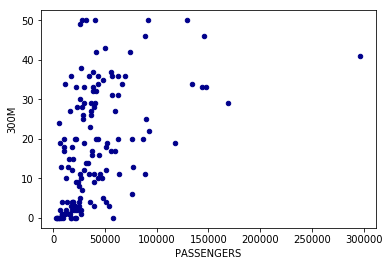

In [127]:
result.plot.scatter(x='PASSENGERS',y='300M',c='DarkBlue')

In [128]:
result[['PASSENGERS','300M']].corr()

,PASSENGERS,300M
PASSENGERS,1.000000,0.460988
300M,0.460988,1.000000


In [129]:
result[['ENTRIES','300M']].corr()

,ENTRIES,300M
ENTRIES,1.0000,0.4502
300M,0.4502,1.0000


In [130]:
result[['EXITS','300M']].corr()

,EXITS,300M
EXITS,1.000000,0.465312
300M,0.465312,1.000000


In [131]:
result['RiderCat'] = None
def get_rider_cat(num):
    cat = 'Raw'
    if num < 30000:
        cat = 'Cat_1'
    else:
        if num < 60000:
            cat = 'Cat_2'
        else:
            if num < 120000:
                cat = 'Cat_3'
            else:
                cat = 'Cat_4'
    return cat

result['RiderCat']=result.apply(lambda x: get_rider_cat(x['PASSENGERS']), axis=1)

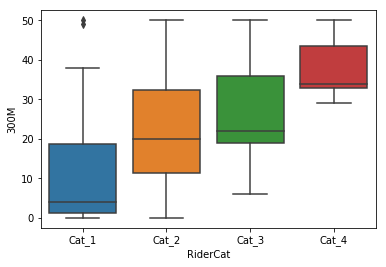

In [132]:
sns.boxplot(x='RiderCat', y='300M', data=result, order=['Cat_1','Cat_2','Cat_3','Cat_4'])

In [133]:
# remove the outlier
result1 = result.loc[result['PASSENGERS']<200000].copy()

Use the seaborn function to show the linear regression result in the scatter plot.

(0, 62.29884252465564)

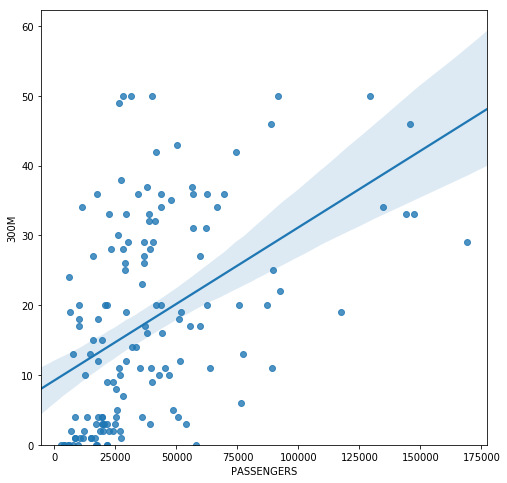

In [134]:
width = 8
height = 8
plt.figure(figsize=(width, height))
sns.regplot(x="PASSENGERS", y="300M", data=result1)
plt.ylim(0,)

Use polynomial regression to check the result. The result is not so good. I decide to stick to the linear one.

In [135]:
def PlotPolly(model, independent_variable, dependent_variabble, Name):
    x_new = np.linspace(1000, 125000, 50)
    y_new = model(x_new)

    plt.plot(independent_variable, dependent_variabble, '.', x_new, y_new, '-')
    plt.title('Polynomial Fit with Matplotlib for Price ~ Length')
    ax = plt.gca()
    ax.set_facecolor((0.898, 0.898, 0.898))
    fig = plt.gcf()
    plt.xlabel(Name)
    plt.ylabel('300M')

    plt.show()
    plt.close()

In [136]:
x = result1['PASSENGERS']
y = result1['300M']

In [137]:
f = np.polyfit(x, y, 1)
p = np.poly1d(f)
print(p)

 
0.0002192 x + 9.233


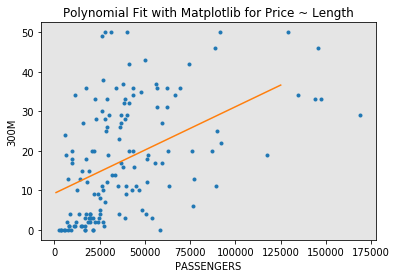

In [138]:
PlotPolly(p, x, y, 'PASSENGERS')

### Some Discussions on the Data

In [139]:
# Case 1. Zero Coffee Shop within 300 m
df_zero_coffee = df_station_coffee[df_station_coffee['300M']==0].copy()
df_zero_coffee.reset_index(drop=True, inplace=True)
df_zero_coffee.head()

,STATION_IDX,STATION,LINENAME,LATITUDE,LONGITUDE,Starbucks,StarbucksAll,100M,200M,300M
0,t1034117,DYCKMAN ST,A,40.865491,-73.927271,0,1,0,0,0
1,t1034118,190 ST,A,40.859022,-73.934180,0,0,0,0,0
2,t1034120,175 ST,A,40.847391,-73.939704,0,0,0,0,0
3,t1041123,155 ST,C,40.830518,-73.941514,0,0,0,0,0
4,t1044126,125 ST,ACBD,40.811109,-73.952343,0,0,0,0,0


In [140]:
# Manhattan coordinate
latitude = 40.7831
longitude = -73.9712

map_zero_stations = folium.Map(location=[latitude, longitude], zoom_start=12) # generate map centred around the Conrad Hotel

for i in range(df_zero_coffee.shape[0]):
    label = f'{df_zero_coffee.iloc[i]["STATION"]}'
    label = folium.Popup(label, parse_html=True)
    lat = float(df_zero_coffee.iloc[i]['LATITUDE'])
    lng = float(df_zero_coffee.iloc[i]['LONGITUDE'])
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_zero_stations) 

map_zero_stations 

In [141]:
# Case 2. Few Coffee Shops within 300 m
df_few_coffee = result.loc[(result['300M']<=5) & (result['PASSENGERS']<30000)].copy()
df_few_coffee.reset_index(drop=True, inplace=True)
df_few_coffee.head()

,STATION_IDX,STATION,LINENAME,LOCATION,PASSENGERS,ENTRIES,EXITS,B_Counts,L_Counts,S_Counts,N_Counts,LATITUDE,LONGITUDE,300M,Starbucks,StarbucksAll,RiderCat
0,t1034116,INWOOD-207 ST,A,"(40.868072, -73.919899)",14885.2,10293.8,4591.4,6105.2,3599.4,3924.8,1255.2,40.868072,-73.919899,1,0,0,Cat_1
1,t1034117,DYCKMAN ST,A,"(40.865491, -73.927271)",7583.8,7385.0,198.8,3780.6,2038.8,1433.8,331.2,40.865491,-73.927271,0,0,1,Cat_1
2,t1034118,190 ST,A,"(40.859022, -73.93418)",3863.6,3299.8,563.8,1854.0,1043.4,772.2,194.0,40.859022,-73.934180,0,0,0,Cat_1
3,t1034119,181 ST,A,"(40.851695, -73.937969)",20300.4,10797.4,9503.0,6918.8,5066.4,6284.4,2031.2,40.851695,-73.937969,3,1,1,Cat_1
4,t1034120,175 ST,A,"(40.847391, -73.939704)",21458.8,14105.8,7353.0,7964.8,5331.2,5941.4,2221.4,40.847391,-73.939704,0,0,0,Cat_1


In [142]:
# Manhattan coordinate
latitude = 40.7831
longitude = -73.9712

map_few_stations = folium.Map(location=[latitude, longitude], zoom_start=12) # generate map centred around the Conrad Hotel

for i in range(df_few_coffee.shape[0]):
    label = f'{df_few_coffee.iloc[i]["STATION"]}'
    label = folium.Popup(label, parse_html=True)
    lat = float(df_few_coffee.iloc[i]['LOCATION'].split(',')[0][1:])
    lng = float(df_few_coffee.iloc[i]['LOCATION'].split(',')[1][:-1])
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_few_stations) 

map_few_stations 

It is shown that all such stations are located in the north. Consider the workday daily activities are mainly in the south, which can explain the sparce sites for coffee shop.

In [143]:
# Case 3. Most Coffee Shops within 300 m
df_most_coffee = result.loc[result['300M']>=35].copy()
df_most_coffee.reset_index(drop=True, inplace=True)
df_most_coffee.head()

,STATION_IDX,STATION,LINENAME,LOCATION,PASSENGERS,ENTRIES,EXITS,B_Counts,L_Counts,S_Counts,N_Counts,LATITUDE,LONGITUDE,300M,Starbucks,StarbucksAll,RiderCat
0,t0002004,TIMES SQ-42 ST,ACENQRS1237W,"(40.755983, -73.986229)",40079.4,16989.6,23089.8,12394.2,9851.2,14409.4,3424.6,40.755983,-73.986229,50,6,10,Cat_2
1,t0003005,34 ST-HERALD SQ,BDFMNQRW,"(40.749719, -73.987823)",88784.6,47953.8,40830.8,23060.8,22216.0,31765.2,11742.6,40.749719,-73.987823,46,4,12,Cat_3
2,t0004006,28 ST,NRW,"(40.745494, -73.988691)",28138.4,13317.2,14821.2,7254.8,8031.2,9923.8,2928.6,40.745494,-73.988691,50,2,4,Cat_1
3,t0012019,FULTON ST,ACJZ2345,"(40.710368, -74.009509)",17278.4,7602.6,9675.8,5448.6,3905.2,7138.8,786.4,40.710368,-74.009509,36,7,12,Cat_1
4,t1003005,34 ST-HERALD SQ,BDFMNQRW,"(40.749719, -73.987823)",145612.2,72651.2,72961.0,39634.8,37784.8,53106.2,15086.4,40.749719,-73.987823,46,4,12,Cat_4


In [144]:
df_most_rider = result.loc[result['PASSENGERS']>=80000].copy()
df_most_rider.reset_index(drop=True, inplace=True)
df_most_rider.head()

,STATION_IDX,STATION,LINENAME,LOCATION,PASSENGERS,ENTRIES,EXITS,B_Counts,L_Counts,S_Counts,N_Counts,LATITUDE,LONGITUDE,300M,Starbucks,StarbucksAll,RiderCat
0,t0003005,34 ST-HERALD SQ,BDFMNQRW,"(40.749719, -73.987823)",88784.6,47953.8,40830.8,23060.8,22216.0,31765.2,11742.6,40.749719,-73.987823,46,4,12,Cat_3
1,t0005008,14 ST-UNION SQ,LNQR456W,"(40.734789, -73.99073)",143912.6,75390.6,68522.0,34557.6,40956.4,54170.0,14228.8,40.734789,-73.990730,33,1,3,Cat_4
2,t1002134,42 ST-PORT AUTH,ACENQRS1237W,"(40.757308, -73.989735)",147472.2,79404.8,68067.4,48583.6,33275.4,50319.2,15294.8,40.757308,-73.989735,33,5,6,Cat_4
3,t1003005,34 ST-HERALD SQ,BDFMNQRW,"(40.749719, -73.987823)",145612.2,72651.2,72961.0,39634.8,37784.8,53106.2,15086.4,40.749719,-73.987823,46,4,12,Cat_4
4,t1045133,59 ST COLUMBUS,ABCD1,"(40.768296, -73.981736)",117432.4,64101.0,53331.4,31164.0,33672.0,38426.0,14170.4,40.768296,-73.981736,19,4,10,Cat_3


In [145]:
# Manhattan coordinate
latitude = 40.7831
longitude = -73.9712

map_most_stations = folium.Map(location=[latitude, longitude], zoom_start=12) # generate map centred around the Conrad Hotel

for i in range(df_most_coffee.shape[0]):
    label = f'{df_most_coffee.iloc[i]["STATION"]}'
    label = folium.Popup(label, parse_html=True)
    lat = float(df_most_coffee.iloc[i]['LOCATION'].split(',')[0][1:])
    lng = float(df_most_coffee.iloc[i]['LOCATION'].split(',')[1][:-1])
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.1,
        parse_html=False).add_to(map_most_stations) 
    
for i in range(df_most_rider.shape[0]):
    label = f'{df_most_rider.iloc[i]["STATION"]}'
    label = folium.Popup(label, parse_html=True)
    lat = float(df_most_rider.iloc[i]['LOCATION'].split(',')[0][1:])
    lng = float(df_most_rider.iloc[i]['LOCATION'].split(',')[1][:-1])
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_most_stations) 

map_most_stations 

In [146]:
# Opportunity
df_chance = result[(result.PASSENGERS>=50000) & (result['300M']<5)].copy()
df_chance.reset_index(drop=True, inplace=True)
df_chance[['STATION', 'LINENAME', 'PASSENGERS', 'ENTRIES', 'EXITS', 'RiderCat', '300M', 'Starbucks']].head()

,STATION,LINENAME,PASSENGERS,ENTRIES,EXITS,RiderCat,300M,Starbucks
0,145 ST,ABCD,50805.2,25418.0,25387.2,Cat_2,4,1
1,125 ST,ACBD,58153.0,31024.6,27128.4,Cat_2,0,0
2,125 ST,456,53925.8,29241.2,24684.6,Cat_2,3,0


In [147]:
# Manhattan coordinate
latitude = 40.7831
longitude = -73.9712

map_chance_stations = folium.Map(location=[latitude, longitude], zoom_start=12) # generate map centred around the Conrad Hotel

for i in range(df_chance.shape[0]):
    label = f'{df_chance.iloc[i]["STATION"]}, "{df_chance.iloc[i]["LINENAME"]}"'
    label = folium.Popup(label, parse_html=True)
    lat = float(df_chance.iloc[i]['LOCATION'].split(',')[0][1:])
    lng = float(df_chance.iloc[i]['LOCATION'].split(',')[1][:-1])
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.1,
        parse_html=False).add_to(map_chance_stations) 
    
map_chance_stations 

Next, we consider the case for those stations with small ridership counts but have more coffee shops.

In [148]:
df_coffee_spot = result.loc[(result['300M']>10) & (result['PASSENGERS']<20000)].copy()
df_coffee_spot.reset_index(drop=True, inplace=True)
df_coffee_spot.head()

,STATION_IDX,STATION,LINENAME,LOCATION,PASSENGERS,ENTRIES,EXITS,B_Counts,L_Counts,S_Counts,N_Counts,LATITUDE,LONGITUDE,300M,Starbucks,StarbucksAll,RiderCat
0,t0004000,59 ST,NRW,"(40.76266, -73.967258)",19374.8,12261.2,7113.6,7329.8,4779.2,5313.6,1952.2,40.762660,-73.967258,15,3,5,Cat_1
1,t0004012,CITY HALL,NRW,"(40.713282, -74.006978)",10066.6,6502.0,3564.6,2564.0,3127.6,3772.6,602.4,40.713282,-74.006978,17,4,9,Cat_1
2,t0004014,RECTOR ST,NRW,"(40.70722, -74.013342)",10042.6,7447.8,2594.8,2832.6,2812.6,3766.6,630.8,40.707220,-74.013342,18,4,7,Cat_1
3,t0009016,DELANCEY/ESSEX,FJMZ,"(40.718315, -73.987437)",17928.0,10550.4,7377.6,6475.8,4876.6,4876.0,1699.4,40.718315,-73.987437,12,1,1,Cat_1
4,t0010017,BOWERY,JZ,"(40.72028, -73.993915)",7777.2,4231.4,3545.8,1631.4,2059.0,2582.0,1504.8,40.720280,-73.993915,13,0,0,Cat_1


In [149]:
# Manhattan coordinate
latitude = 40.7831
longitude = -73.9712

map_spot_stations = folium.Map(location=[latitude, longitude], zoom_start=12) # generate map centred around the Conrad Hotel

for i in range(df_coffee_spot.shape[0]):
    label = f'{df_coffee_spot.iloc[i]["STATION"]}: {df_coffee_spot.iloc[i]["300M"]} shops'
    label = folium.Popup(label, parse_html=True)
    lat = float(df_coffee_spot.iloc[i]['LOCATION'].split(',')[0][1:])
    lng = float(df_coffee_spot.iloc[i]['LOCATION'].split(',')[1][:-1])
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_spot_stations) 

map_spot_stations

It is found that most of such stations are located in downtown and midtown where there exist a lot of business places. Meanwhile, it should be noted that in these places, the stations are very close to one another which accumulates a large population. Another issue should be noticed here is that besides MTA subways, many downtown commuters also relies on PATH and other public transportation systems, therefore, it also brings a lot of customers.

In [150]:
result['300M'].sum()

2596

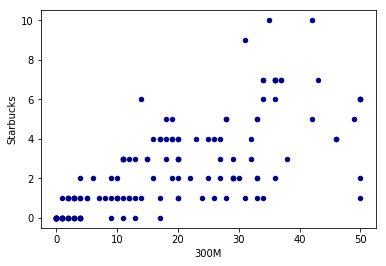

In [151]:
result1.plot.scatter(x='300M',y='Starbucks',c='DarkBlue')

# This plot shows that the site strategy of Starbuck has the positive correlation with the total number of coffee shops. However,
# it should also be noted that this is only one of the factors that impact the franchise site selection. The other factors include
# the total street flow, available site and capacity, real estate cost, and local competition and alternatives. Due to the time and
# resource limit, here I just give a rough analysis on one of the many factors. At least, Starbucks share the similar view of the
# market needs as its peer competitors.

In [152]:
result[['PASSENGERS','StarbucksAll']].corr()

,PASSENGERS,StarbucksAll
PASSENGERS,1.000000,0.434211
StarbucksAll,0.434211,1.000000


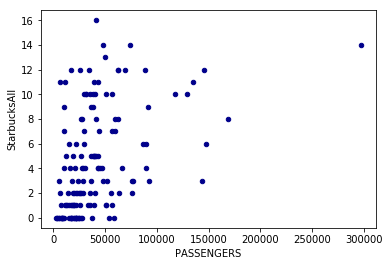

In [153]:
result.plot.scatter(x='PASSENGERS',y='StarbucksAll',c='DarkBlue')

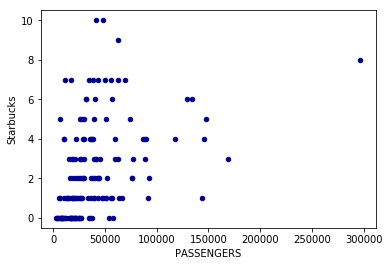

In [154]:
result.plot.scatter(x='PASSENGERS',y='Starbucks',c='DarkBlue')

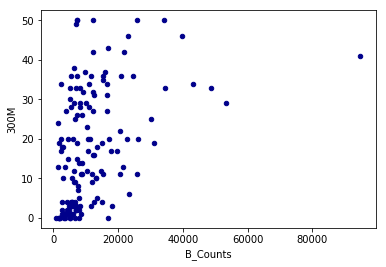

In [155]:
# The following plots show the relationship between ridership in different time and the coffee shop
# However, they show the similar type. The reasons can be (1) coffee shops are popular place for refreshment in every day time 
# periods. (2) there are other food venues which are not included here, such as restaraunts, fast food, and convenience stores. 
# These factors also affect the whole food service network for NYC subway riders. 
result.plot.scatter(x='B_Counts',y='300M',c='DarkBlue')

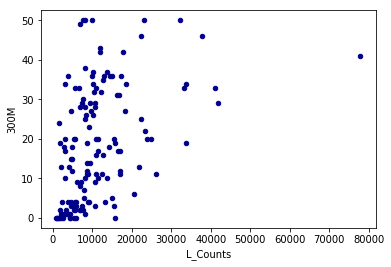

In [156]:
result.plot.scatter(x='L_Counts',y='300M',c='DarkBlue')

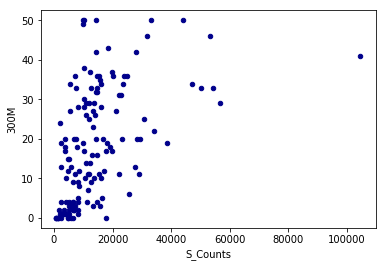

In [157]:
result.plot.scatter(x='S_Counts',y='300M',c='DarkBlue')

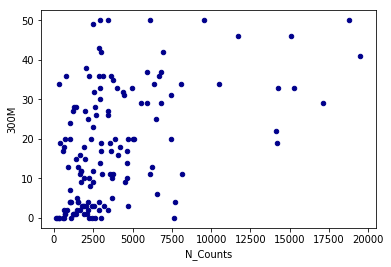

In [158]:
result.plot.scatter(x='N_Counts',y='300M',c='DarkBlue')

In [159]:
print("In a weekday")
print(f"Starbucks shop number: {df_dict_starbucks.shape[0]}, covering the total ridership: {sum(result[result['Starbucks']!=0]['PASSENGERS'].tolist())} ({sum(result[result['Starbucks']!=0]['PASSENGERS'].tolist())/sum(result['PASSENGERS'].tolist())})")
print(f"Starbucks shop number: {df_dict_starbucks_all.shape[0]}, covering the total ridership: {sum(result[result['StarbucksAll']!=0]['PASSENGERS'].tolist())} ({sum(result[result['StarbucksAll']!=0]['PASSENGERS'].tolist())/sum(result['PASSENGERS'].tolist())})")
print(f"Coffee shop number: {df_dict_shops.shape[0]}, covering the total ridership: {sum(result['PASSENGERS'].tolist())}")

In a weekday
Starbucks shop number: 136, covering the total ridership: 5206800.000000001 (0.8844384992674691)
Starbucks shop number: 246, covering the total ridership: 5325643.2 (0.9046254665902285)
Coffee shop number: 1021, covering the total ridership: 5887125.000000002


In [160]:
df_tt_slim_weekend = pd.read_csv("turnstile_weekend.csv")
result_weekend = pd.concat([df_tt_slim_weekend, df_station_coffee[['300M', 'Starbucks', 'StarbucksAll']]], axis=1, join='inner')
result_weekend.head()
print("In a weekend")
print(f"Starbucks shop number: {df_dict_starbucks.shape[0]}, covering the total ridership: {sum(result_weekend[result_weekend['Starbucks']!=0]['PASSENGERS'].tolist())} ({sum(result_weekend[result_weekend['Starbucks']!=0]['PASSENGERS'].tolist())/sum(result_weekend['PASSENGERS'].tolist())})")
print(f"Starbucks shop number: {df_dict_starbucks_all.shape[0]}, covering the total ridership: {sum(result_weekend[result_weekend['StarbucksAll']!=0]['PASSENGERS'].tolist())} ({sum(result_weekend[result_weekend['StarbucksAll']!=0]['PASSENGERS'].tolist())/sum(result_weekend['PASSENGERS'].tolist())})")
print(f"Coffee shop number: {df_dict_shops.shape[0]}, covering the total ridership: {sum(result_weekend['PASSENGERS'].tolist())}")


In a weekend
Starbucks shop number: 136, covering the total ridership: 2349247.0 (0.8609165029942929)
Starbucks shop number: 246, covering the total ridership: 2413639.0 (0.8845139090826303)
Coffee shop number: 1021, covering the total ridership: 2728774.5


In [161]:
import geopy.distance

In [162]:
df_dict_shops['Metric'] = None

In [163]:
for i in range(df_dict_shops.shape[0]):
    print(i)
    lst_stations = []
    lst_metrics = []
    nearest_station = None
    distance_station = 1000
    for j in range(df_tt_slim_workday.shape[0]):
        coords_1 = (df_dict_shops.iloc[i]['Lat'], df_dict_shops.iloc[i]['Lng'])
        coords_2 = (df_tt_slim_workday.iloc[j]['LATITUDE'], df_tt_slim_workday.iloc[j]['LONGITUDE'])
        d = geopy.distance.distance(coords_1, coords_2).m
        if d < distance_station:
            distance_station = d
            nearest_station = df_tt_slim_workday.iloc[j]['STATION_IDX']
        #if d < 330 and d > 0:
            #lst_stations.append(df_tt_slim_workday.iloc[j]['STATION_IDX'])
            #metric = df_tt_slim_workday.iloc[j]['PASSENGERS'] #/ (d*d)
            #lst_metrics.append(metric)
    #print(f'Coffee Shop #{i} has access to subway {lst_stations} and metric {sum(lst_metrics)}')
    #df_dict_shops.at[i, 'Metric'] = sum(lst_metrics)
    print(f'Coffee Shop #{i} is close to subway {nearest_station} in {distance_station}')
    df_dict_shops.at[i, 'Metric'] = distance_station
    
        

0
Coffee Shop #0 is close to subway t0000000 in 235.46625644208285
1
Coffee Shop #1 is close to subway t0001001 in 245.83473218270558
2
Coffee Shop #2 is close to subway t1069230 in 99.41743277531579
3
Coffee Shop #3 is close to subway t0000000 in 73.60834598414174
4
Coffee Shop #4 is close to subway t1062184 in 266.1809410794745
5
Coffee Shop #5 is close to subway t0000000 in 108.77375943882896
6
Coffee Shop #6 is close to subway t0000000 in 171.30197491055443
7
Coffee Shop #7 is close to subway t0000000 in 269.58056565523117
8
Coffee Shop #8 is close to subway t1062184 in 269.98097259264375
9
Coffee Shop #9 is close to subway t0001001 in 252.70664501719946
10
Coffee Shop #10 is close to subway t0000000 in 185.29616939943764
11
Coffee Shop #11 is close to subway t0000000 in 113.06985004624676
12
Coffee Shop #12 is close to subway t1069230 in 166.29747796808633
13
Coffee Shop #13 is close to subway t0000000 in 293.6509736367433
14
Coffee Shop #14 is close to subway t1062184 in 223.9550

Coffee Shop #120 is close to subway t1002134 in 159.7226678930712
121
Coffee Shop #121 is close to subway t1073213 in 256.85451423331085
122
Coffee Shop #122 is close to subway t1002134 in 54.63613504398113
123
Coffee Shop #123 is close to subway t1072212 in 220.6549014441043
124
Coffee Shop #124 is close to subway t1002134 in 28.12710230589374
125
Coffee Shop #125 is close to subway t1073213 in 181.65773460771933
126
Coffee Shop #126 is close to subway t1002134 in 101.38569905366515
127
Coffee Shop #127 is close to subway t1002134 in 48.98420775022392
128
Coffee Shop #128 is close to subway t0002004 in 319.3209517159136
129
Coffee Shop #129 is close to subway t1073213 in 90.31305781300048
130
Coffee Shop #130 is close to subway t1073213 in 79.83329821180571
131
Coffee Shop #131 is close to subway t0003005 in 245.3507274411275
132
Coffee Shop #132 is close to subway t3082135 in 145.23897249837458
133
Coffee Shop #133 is close to subway t0003005 in 120.91397212997741
134
Coffee Shop #13

Coffee Shop #237 is close to subway t3091277 in 251.22558592535682
238
Coffee Shop #238 is close to subway t3090278 in 90.33525783288356
239
Coffee Shop #239 is close to subway t3090278 in 159.03210201665465
240
Coffee Shop #240 is close to subway t3090278 in 179.26771389385087
241
Coffee Shop #241 is close to subway t0004009 in 269.45030171198783
242
Coffee Shop #242 is close to subway t0005008 in 175.75799221395872
243
Coffee Shop #243 is close to subway t3090278 in 209.22865455919248
244
Coffee Shop #244 is close to subway t3090278 in 75.10663180092668
245
Coffee Shop #245 is close to subway t3090278 in 59.25254662375945
246
Coffee Shop #246 is close to subway t0004009 in 92.7035309049367
247
Coffee Shop #247 is close to subway t3090278 in 32.795212438803375
248
Coffee Shop #248 is close to subway t0004009 in 92.07438753023345
249
Coffee Shop #249 is close to subway t0004009 in 235.60995052530083
250
Coffee Shop #250 is close to subway t0005008 in 186.18614255959022
251
Coffee Shop 

Coffee Shop #354 is close to subway t0005008 in 206.04665703436658
355
Coffee Shop #355 is close to subway t0006011 in 23.98495196676171
356
Coffee Shop #356 is close to subway t0006011 in 120.53948673788389
357
Coffee Shop #357 is close to subway t0006011 in 173.215899533571
358
Coffee Shop #358 is close to subway t0006011 in 177.93909018855598
359
Coffee Shop #359 is close to subway t0006011 in 267.8701828079555
360
Coffee Shop #360 is close to subway t0006011 in 75.67520169013335
361
Coffee Shop #361 is close to subway t0006011 in 180.65821983792975
362
Coffee Shop #362 is close to subway t0006011 in 112.62061947701328
363
Coffee Shop #363 is close to subway t0006011 in 134.17245756599942
364
Coffee Shop #364 is close to subway t0006011 in 128.80850925222185
365
Coffee Shop #365 is close to subway t0006011 in 159.38876502904623
366
Coffee Shop #366 is close to subway t0006011 in 221.33784017453286
367
Coffee Shop #367 is close to subway t0006011 in 54.636636807596794
368
Coffee Shop

Coffee Shop #472 is close to subway t0029054 in 45.889148071614464
473
Coffee Shop #473 is close to subway t1030136 in 143.36696503273018
474
Coffee Shop #474 is close to subway t1030136 in 67.4257541911408
475
Coffee Shop #475 is close to subway t0030069 in 146.70953123331557
476
Coffee Shop #476 is close to subway t0030069 in 44.10887254427646
477
Coffee Shop #477 is close to subway t0030069 in 51.15854617135429
478
Coffee Shop #478 is close to subway t0030069 in 133.93208139277974
479
Coffee Shop #479 is close to subway t0030069 in 127.74022649864791
480
Coffee Shop #480 is close to subway t0030069 in 146.8539633525892
481
Coffee Shop #481 is close to subway t3078263 in 96.15996994307974
482
Coffee Shop #482 is close to subway t1030136 in 78.4289033631792
483
Coffee Shop #483 is close to subway t0030069 in 289.78746004912756
484
Coffee Shop #484 is close to subway t3078263 in 192.21725158256174
485
Coffee Shop #485 is close to subway t0030069 in 311.900669496419
486
Coffee Shop #486

Coffee Shop #590 is close to subway t1043130 in 18.820019975329647
591
Coffee Shop #591 is close to subway t1043130 in 303.21693756397116
592
Coffee Shop #592 is close to subway t1043130 in 271.0264709401524
593
Coffee Shop #593 is close to subway t1043130 in 111.34982866783814
594
Coffee Shop #594 is close to subway t1043131 in 205.6058236241631
595
Coffee Shop #595 is close to subway t1043131 in 278.803319473304
596
Coffee Shop #596 is close to subway t1043131 in 98.88405133660923
597
Coffee Shop #597 is close to subway t1043131 in 285.8955539852777
598
Coffee Shop #598 is close to subway t3082132 in 305.22039611776825
599
Coffee Shop #599 is close to subway t1043132 in 306.61000553487236
600
Coffee Shop #600 is close to subway t3087133 in 298.98275701426905
601
Coffee Shop #601 is close to subway t3087133 in 247.88463708064523
602
Coffee Shop #602 is close to subway t3087133 in 90.36793001595036
603
Coffee Shop #603 is close to subway t3087133 in 16.942426097264654
604
Coffee Shop #

Coffee Shop #708 is close to subway t1058075 in 361.03990701587196
709
Coffee Shop #709 is close to subway t1058075 in 279.50764638123695
710
Coffee Shop #710 is close to subway t1058075 in 315.04536242430197
711
Coffee Shop #711 is close to subway t1069216 in 308.3860713496156
712
Coffee Shop #712 is close to subway t1069216 in 233.55838336384275
713
Coffee Shop #713 is close to subway t1061183 in 305.68827325015934
714
Coffee Shop #714 is close to subway t1061183 in 86.66157714021432
715
Coffee Shop #715 is close to subway t1061183 in 152.493870486265
716
Coffee Shop #716 is close to subway t1072212 in 234.55978250874597
717
Coffee Shop #717 is close to subway t1061183 in 97.90054333779985
718
Coffee Shop #718 is close to subway t1061183 in 89.29672607703365
719
Coffee Shop #719 is close to subway t1061183 in 108.10092961173741
720
Coffee Shop #720 is close to subway t1061183 in 204.00754878414966
721
Coffee Shop #721 is close to subway t1061183 in 241.7508451965247
722
Coffee Shop #

Coffee Shop #825 is close to subway t3078129 in 62.858904439203
826
Coffee Shop #826 is close to subway t3078246 in 194.5382297412119
827
Coffee Shop #827 is close to subway t3078246 in 226.4705068386843
828
Coffee Shop #828 is close to subway t3078246 in 254.134123306392
829
Coffee Shop #829 is close to subway t3078246 in 323.8491437836515
830
Coffee Shop #830 is close to subway t3078246 in 286.43037825157194
831
Coffee Shop #831 is close to subway t3078259 in 349.0897859535682
832
Coffee Shop #832 is close to subway t3078259 in 308.5677907491926
833
Coffee Shop #833 is close to subway t3078259 in 312.03889760020127
834
Coffee Shop #834 is close to subway t3078259 in 271.1429753141347
835
Coffee Shop #835 is close to subway t3078259 in 290.58061983599936
836
Coffee Shop #836 is close to subway t3082018 in 224.26885658362482
837
Coffee Shop #837 is close to subway t3078261 in 313.28955440154067
838
Coffee Shop #838 is close to subway t3078261 in 187.31830057362035
839
Coffee Shop #839 

Coffee Shop #942 is close to subway t3090278 in 313.56343641339424
943
Coffee Shop #943 is close to subway t3090278 in 387.66480461664275
944
Coffee Shop #944 is close to subway t3090279 in 61.84183246419718
945
Coffee Shop #945 is close to subway t3090279 in 129.9300150939775
946
Coffee Shop #946 is close to subway t3090279 in 113.60487946022565
947
Coffee Shop #947 is close to subway t3090279 in 87.22456322136823
948
Coffee Shop #948 is close to subway t3090279 in 269.70341881870803
949
Coffee Shop #949 is close to subway t3090279 in 297.6187201336602
950
Coffee Shop #950 is close to subway t3090279 in 109.36745140426001
951
Coffee Shop #951 is close to subway t3090279 in 405.66697355841967
952
Coffee Shop #952 is close to subway t3090281 in 346.04969697677916
953
Coffee Shop #953 is close to subway t3090281 in 206.5058886563445
954
Coffee Shop #954 is close to subway t3090281 in 272.01394409440246
955
Coffee Shop #955 is close to subway t3090281 in 319.36969107008116
956
Coffee Shop

In [164]:
df_dict_shops = df_dict_shops.astype({'Metric': 'float64'})
df_dict_shops.describe()

,Unnamed: 0,Lat,Lng,Metric
count,1021.000000,1021.000000,1021.000000,1021.000000
mean,510.000000,40.748911,-73.986221,175.918886
std,294.881615,0.027485,0.017062,91.466672
min,0.000000,40.702044,-74.017495,3.235753
25%,255.000000,40.729798,-73.997555,100.537744
50%,510.000000,40.747637,-73.988354,177.939090
75%,765.000000,40.760567,-73.979083,247.197265
max,1020.000000,40.874555,-73.908730,418.230418


In [165]:
df_dict_shops[df_dict_shops.Metric > 5000]

,Unnamed: 0,ID,Name,Lat,Lng,Metric


In [166]:
df_dict_shops.shape[0]

1021

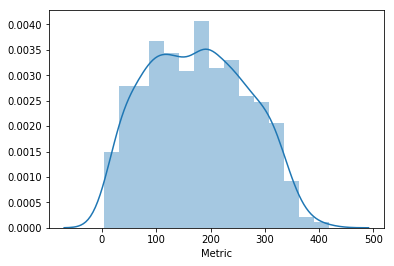

In [167]:
sns.distplot(df_dict_shops.Metric)

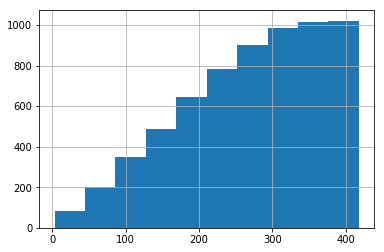

In [168]:
df_dict_shops.Metric.hist( cumulative = True )

In [169]:
# distance calculation between two points using their latitude and longitude information
# Use geopy module
# https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude

import geopy.distance

coords_1 = (40.576209, -73.967875)
coords_2 = (40.576507, -73.969445)

d = geopy.distance.distance(coords_1, coords_2).m
print(d)

136.99125557229425


In [170]:
df_dict_starbucks['Metric'] = None

In [171]:
for i in range(df_dict_starbucks.shape[0]):
    print(i)
    lst_stations = []
    lst_metrics = []
    nearest_station = None
    distance_station = 1000
    for j in range(df_tt_slim_workday.shape[0]):
        coords_1 = (df_dict_starbucks.iloc[i]['Lat'], df_dict_starbucks.iloc[i]['Lng'])
        coords_2 = (df_tt_slim_workday.iloc[j]['LATITUDE'], df_tt_slim_workday.iloc[j]['LONGITUDE'])
        d = geopy.distance.distance(coords_1, coords_2).m
        if d < distance_station:
            distance_station = d
            nearest_station = df_tt_slim_workday.iloc[j]['STATION_IDX']
        #if d < 330 and d > 0:
            #lst_stations.append(df_tt_slim_workday.iloc[j]['STATION_IDX'])
            #metric = df_tt_slim_workday.iloc[j]['PASSENGERS'] #/ (d*d)
            #lst_metrics.append(metric)
    #print(f'Coffee Shop #{i} has access to subway {lst_stations} and metric {sum(lst_metrics)}')
    #df_dict_starbucks.at[i, 'Metric'] = sum(lst_metrics)
    print(f'Coffee Shop #{i} is close to subway {nearest_station} in {distance_station}')
    df_dict_starbucks.at[i, 'Metric'] = distance_station

0
Coffee Shop #0 is close to subway t0000000 in 113.06985004624676
1
Coffee Shop #1 is close to subway t0004000 in 131.205167622883
2
Coffee Shop #2 is close to subway t1062184 in 232.72552380399748
3
Coffee Shop #3 is close to subway t0000000 in 169.59227250401653
4
Coffee Shop #4 is close to subway t0001001 in 269.62935747510977
5
Coffee Shop #5 is close to subway t0001002 in 47.21766528765533
6
Coffee Shop #6 is close to subway t1060021 in 148.6919874875689
7
Coffee Shop #7 is close to subway t1069229 in 32.139814130596285
8
Coffee Shop #8 is close to subway t1069229 in 101.13077843835767
9
Coffee Shop #9 is close to subway t1069229 in 122.54611180958156
10
Coffee Shop #10 is close to subway t1060021 in 105.26166027495431
11
Coffee Shop #11 is close to subway t3087133 in 129.65842972860992
12
Coffee Shop #12 is close to subway t0001002 in 100.53774406152134
13
Coffee Shop #13 is close to subway t0001002 in 144.4191935975934
14
Coffee Shop #14 is close to subway t0001003 in 91.468424

Coffee Shop #120 is close to subway t3090279 in 109.36745140426001
121
Coffee Shop #121 is close to subway t3090281 in 256.44444461829823
122
Coffee Shop #122 is close to subway t3090281 in 261.453162844828
123
Coffee Shop #123 is close to subway t3090281 in 285.9488952549214
124
Coffee Shop #124 is close to subway t3090281 in 214.8522003795946
125
Coffee Shop #125 is close to subway t3090281 in 281.4514198078298
126
Coffee Shop #126 is close to subway t3093280 in 64.62531809449993
127
Coffee Shop #127 is close to subway t3093280 in 94.93992341910415
128
Coffee Shop #128 is close to subway t3093280 in 121.65519498756943
129
Coffee Shop #129 is close to subway t3093280 in 267.03644362394846
130
Coffee Shop #130 is close to subway t3093280 in 99.50865421808814
131
Coffee Shop #131 is close to subway t3093280 in 327.8146540728925
132
Coffee Shop #132 is close to subway t3093280 in 261.1991151536769
133
Coffee Shop #133 is close to subway t3102330 in 238.0942940594552
134
Coffee Shop #134 

In [172]:
df_dict_starbucks = df_dict_starbucks.astype({'Metric': 'float64'})
df_dict_starbucks.describe()

,Unnamed: 0,Lat,Lng,Metric
count,136.000000,136.000000,136.000000,136.000000
mean,67.500000,40.753850,-73.983832,159.935432
std,39.403892,0.029176,0.017949,89.228744
min,0.000000,40.702785,-74.015458,14.396853
25%,33.750000,40.737739,-73.995461,91.384412
50%,67.500000,40.755207,-73.983865,144.565873
75%,101.250000,40.763999,-73.975037,237.515257
max,135.000000,40.873234,-73.908730,343.669342


In [173]:
df_dict_starbucks[df_dict_starbucks.Metric == 0]

,Unnamed: 0,ID,Name,Lat,Lng,Metric


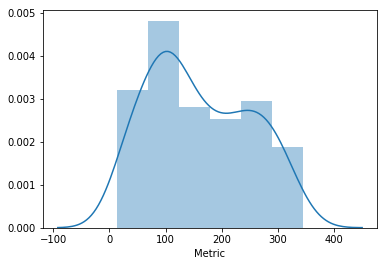

In [174]:
sns.distplot(df_dict_starbucks.Metric)

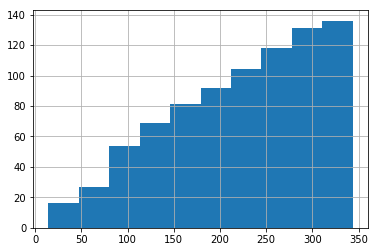

In [175]:
df_dict_starbucks.Metric.hist( cumulative = True )

In [176]:
df_dict_starbucks_all['Metric'] = None

for i in range(df_dict_starbucks_all.shape[0]):
    print(i)
    lst_stations = []
    lst_metrics = []
    nearest_station = None
    distance_station = 1000
    for j in range(df_tt_slim_workday.shape[0]):
        coords_1 = (df_dict_starbucks_all.iloc[i]['Lat'], df_dict_starbucks_all.iloc[i]['Lng'])
        coords_2 = (df_tt_slim_workday.iloc[j]['LATITUDE'], df_tt_slim_workday.iloc[j]['LONGITUDE'])
        d = geopy.distance.distance(coords_1, coords_2).m
        if d < distance_station:
            distance_station = d
            nearest_station = df_tt_slim_workday.iloc[j]['STATION_IDX']
        #if d < 330 and d > 0:
            #lst_stations.append(df_tt_slim_workday.iloc[j]['STATION_IDX'])
            #metric = df_tt_slim_workday.iloc[j]['PASSENGERS'] #/ (d*d)
            #lst_metrics.append(metric)
    #print(f'Coffee Shop #{i} has access to subway {lst_stations} and metric {sum(lst_metrics)}')
    #df_dict_starbucks_all.at[i, 'Metric'] = sum(lst_metrics)
    print(f'Coffee Shop #{i} is close to subway {nearest_station} in {distance_station}')
    df_dict_starbucks_all.at[i, 'Metric'] = distance_station

    

0
Coffee Shop #0 is close to subway t0000000 in 113.06985004624676
1
Coffee Shop #1 is close to subway t1069230 in 29.842336791514757
2
Coffee Shop #2 is close to subway t0004000 in 131.205167622883
3
Coffee Shop #3 is close to subway t1062184 in 232.72552380399748
4
Coffee Shop #4 is close to subway t0000000 in 169.59227250401653
5
Coffee Shop #5 is close to subway t1069230 in 161.7391515302092
6
Coffee Shop #6 is close to subway t0001001 in 212.47337153392155
7
Coffee Shop #7 is close to subway t0001001 in 269.62935747510977
8
Coffee Shop #8 is close to subway t1060021 in 148.6919874875689
9
Coffee Shop #9 is close to subway t1069229 in 32.139814130596285
10
Coffee Shop #10 is close to subway t0001002 in 47.21766528765533
11
Coffee Shop #11 is close to subway t1069229 in 101.13077843835767
12
Coffee Shop #12 is close to subway t3087133 in 129.65842972860992
13
Coffee Shop #13 is close to subway t1069229 in 122.54611180958156
14
Coffee Shop #14 is close to subway t1060021 in 105.26166

Coffee Shop #121 is close to subway t3095052 in 108.051661900167
122
Coffee Shop #122 is close to subway t1017237 in 237.32224481249423
123
Coffee Shop #123 is close to subway t3095052 in 225.34439882960297
124
Coffee Shop #124 is close to subway t3095052 in 172.01974085566067
125
Coffee Shop #125 is close to subway t1017238 in 197.6167054182322
126
Coffee Shop #126 is close to subway t1017238 in 191.1327960623127
127
Coffee Shop #127 is close to subway t1029136 in 260.28489650332085
128
Coffee Shop #128 is close to subway t1034117 in 8.117990268265183
129
Coffee Shop #129 is close to subway t1034119 in 86.967783312123
130
Coffee Shop #130 is close to subway t1040121 in 74.29453414099956
131
Coffee Shop #131 is close to subway t1040121 in 244.53630860408342
132
Coffee Shop #132 is close to subway t1042124 in 204.4748647175484
133
Coffee Shop #133 is close to subway t1043052 in 288.2625051353761
134
Coffee Shop #134 is close to subway t1043125 in 308.9164448503675
135
Coffee Shop #135 i

Coffee Shop #238 is close to subway t3093280 in 154.29834471783633
239
Coffee Shop #239 is close to subway t3093280 in 54.5281833220753
240
Coffee Shop #240 is close to subway t3093280 in 64.31009498005314
241
Coffee Shop #241 is close to subway t3093280 in 176.2870445776174
242
Coffee Shop #242 is close to subway t3095052 in 82.05190651972036
243
Coffee Shop #243 is close to subway t3103351 in 322.8443531805172
244
Coffee Shop #244 is close to subway t3103351 in 91.21602775442676
245
Coffee Shop #245 is close to subway t3103351 in 135.06212171418633


In [177]:
    
df_dict_starbucks_all = df_dict_starbucks_all.astype({'Metric': 'float64'})
df_dict_starbucks_all.describe()

,Unnamed: 0,Lat,Lng,Metric
count,246.000000,246.000000,246.000000,246.000000
mean,122.500000,40.752155,-73.984668,162.201715
std,71.158274,0.030087,0.018166,87.225482
min,0.000000,40.702546,-74.015458,8.117990
25%,61.250000,40.735041,-73.996069,91.742395
50%,122.500000,40.753241,-73.984815,148.873470
75%,183.750000,40.763374,-73.977426,228.007141
max,245.000000,40.873755,-73.908613,389.762977


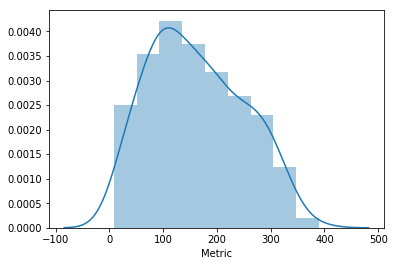

In [178]:
sns.distplot(df_dict_starbucks_all.Metric)

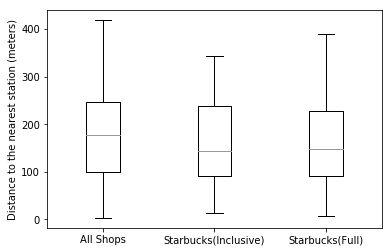

In [179]:
data = [df_dict_shops['Metric'].tolist(), df_dict_starbucks['Metric'].tolist(), df_dict_starbucks_all['Metric'].tolist()]
fig7, ax7 = plt.subplots()
#ax7.set_title('Multiple Samples with Different sizes')
ax7.boxplot(data, labels=['All Shops','Starbucks(Inclusive)','Starbucks(Full)'])
ax7.set_ylabel('Distance to the nearest station (meters)')
plt.show()